# Machine learning analysis

In this notebook are shown all the steps towards an optimal and accurate prediccion of activities

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
sns.set()

Let's first load the dataframe generated after analyzing all the images:

In [45]:
df=pd.read_csv('ntcir12.csv',sep=',', index_col='Unnamed: 0')

This are the tags given by the YOLO processing:

In [60]:
tags=['person','chair', 'book', 'tvmonitor', 'laptop', 'bottle','cup', 'car','diningtable', 'cell phone',
             'keyboard', 'bowl', 'mouse', 'clock','toilet', 'sink', 'remote', 'suitcase', 'pottedplant','refrigerator',
             'knife', 'handbag', 'vase', 'aeroplane', 'cat','bed', 'sofa', 'backpack', 'tie', 'spoon', 'toothbrush',
             'traffic light', 'bicycle', 'train', 'bird', 'microwave', 'bench','fork', 'oven', 'motorbike', 'donut',
             'wine glass', 'pizza','apple', 'scissors', 'umbrella', 'cake', 'bus', 'truck','banana', 'parking meter',
             'sandwich', 'sports ball', 'broccoli','carrot', 'orange', 'teddy bear', 'dog', 'snowboard','skateboard', 'boat',
             'surfboard', 'frisbee', 'skis', 'hot dog','bear', 'elephant', 'toaster', 'stop sign', 'hair drier', 'kite',
             'sheep', 'zebra', 'tennis racket', 'baseball bat', 'fire hydrant','horse', 'cow', 'giraffe', 'baseball glove']

In [61]:
df.index = pd.to_datetime(df.index)

In [62]:
df.head(5)

,user,age,day_id,date,image_directory,activity,image_id,image_path,location,gender,...,G_bin7,G_bin8,B_bin1,B_bin2,B_bin3,B_bin4,B_bin5,B_bin6,B_bin7,B_bin8
2015-02-23 07:08:12,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,mobile,u1_2015-02-23_070812_6,/u1/2015-02-23/b00000006_21i6bq_20150223_07081...,Home,male,...,0.034097,0.052746,0.022873,0.256494,0.174103,0.303694,0.250870,0.168284,0.019045,0.061411
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_7,/u1/2015-02-23/b00000007_21i6bq_20150223_07081...,Home,male,...,0.000065,0.000076,0.067223,0.143474,0.209524,0.444543,0.343550,0.001700,0.000072,0.000061
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_8,/u1/2015-02-23/b00000008_21i6bq_20150223_07081...,Home,male,...,0.005265,0.014378,0.155595,0.260709,0.214408,0.441503,0.075073,0.009980,0.005148,0.011784
2015-02-23 07:08:14,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070814_9,/u1/2015-02-23/b00000009_21i6bq_20150223_07081...,Home,male,...,0.003570,0.003003,0.136579,0.447956,0.280991,0.263809,0.031977,0.004851,0.002074,0.001339
2015-02-23 07:08:22,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070822_10,/u1/2015-02-23/b00000010_21i6bq_20150223_07082...,Home,male,...,0.008912,0.000051,0.044834,0.181883,0.267774,0.521107,0.135849,0.002264,0.002486,0.053487


In [49]:
# import modules 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix

In [50]:
#import different Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#import other features
from sklearn.metrics import accuracy_score

Our first try is with the tags generated by YOLO for each image and with a simple classifier, a k-nearest neighbors algorithm (k-NN):

In [8]:
# will use KNN as the initial classifier
acc_neigh=[]
X1=df[tags]
y1=df['activity']
for neighbor in xrange(1,12): #iterate using different neighbours from 1 to 10
    acc= []
    for i in xrange(10): #iterate 10 times for every neighbour
        x_train1, x_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.3) 
        knn= KNeighborsClassifier(n_neighbors=neighbor)
        knn.fit(x_train1,y_train1)
        acc.append(knn.score(x_test1,y_test1)) # accuracy score
    acc_neigh.append(np.mean(acc)) # append mean value for every neighbour
    print 'neighbor {} processed'.format(neighbor)
   

neighbor 1 processed
neighbor 2 processed
neighbor 3 processed
neighbor 4 processed
neighbor 5 processed
neighbor 6 processed
neighbor 7 processed
neighbor 8 processed
neighbor 9 processed
neighbor 10 processed
neighbor 11 processed


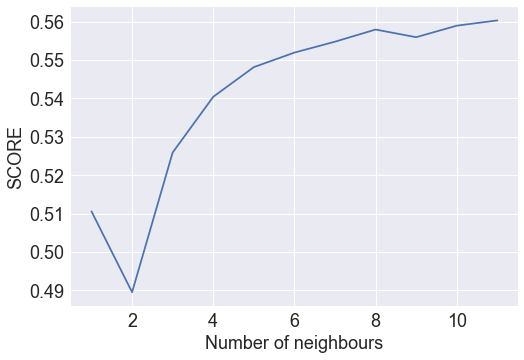

In [9]:
# plot the results
scores = acc_neigh
plt.plot(np.arange(1,12),scores)
plt.xlabel('Number of neighbours',fontsize= 18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylabel('SCORE',fontsize= 18)
plt.show()         

In [10]:
PRC = 0.3
acc_r=np.zeros((10,5))
X=df[tags]
y=df['activity']
for i in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
    nn2 = KNeighborsClassifier(n_neighbors=2)
    nn5 = KNeighborsClassifier(n_neighbors=5)
    svc = SVC()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier(n_estimators=100)
    
    nn2.fit(X_train,y_train)
    nn5.fit(X_train,y_train)
    svc.fit(X_train,y_train)
    dt.fit(X_train,y_train)
    rf.fit(X_train,y_train)   
    
    y_pred_nn2=nn2.predict(X_test)
    y_pred_nn5=nn5.predict(X_test)
    y_pred_svc=svc.predict(X_test)
    y_pred_dt=dt.predict(X_test)
    y_pred_rf=rf.predict(X_test)
    
    acc_r[i][0] = accuracy_score(y_pred_nn2, y_test)
    acc_r[i][1] = accuracy_score(y_pred_nn5, y_test)
    acc_r[i][2] = accuracy_score(y_pred_svc, y_test)
    acc_r[i][3] = accuracy_score(y_pred_dt, y_test)
    acc_r[i][4] = accuracy_score(y_pred_rf, y_test)

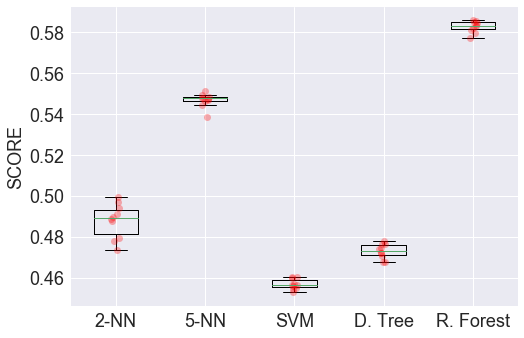

In [21]:
plt.boxplot(acc_r);
for i in xrange(5):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['2-NN','5-NN','SVM','D. Tree', 'R. Forest'],fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylabel('SCORE',fontsize= 18)
plt.show()

In [95]:
PRC = 0.3
X=df[tags]
y=df['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)   
y_pred_rf=rf.predict(X_test)
print accuracy_score(y_test,y_pred_rf)

0.584938581798


As seen in the graph above, Random Forest with 100 estimators gives the best accuracy.

In [13]:
print classification_report(y_test,y_pred_rf)

                             precision    recall  f1-score   support

        attending a seminar       0.43      0.45      0.44       304
                     biking       0.66      0.42      0.51        83
        cleaning and chores       0.51      0.38      0.44       260
                    cooking       0.51      0.36      0.42       180
                    driving       0.53      0.61      0.57       854
having drinks with somebody       0.43      0.44      0.43       402
   having drinks\meal alone       0.63      0.45      0.52       471
  having meal with somebody       0.66      0.63      0.65       312
                    meeting       0.48      0.36      0.41       542
                     mobile       0.58      0.64      0.61      1400
                      plane       0.63      0.50      0.56       300
                    reading       0.57      0.48      0.52       360
                    resting       0.67      0.82      0.74      1537
                   shopping      

In [14]:
y_train[y_train == 'biking'].count()

168

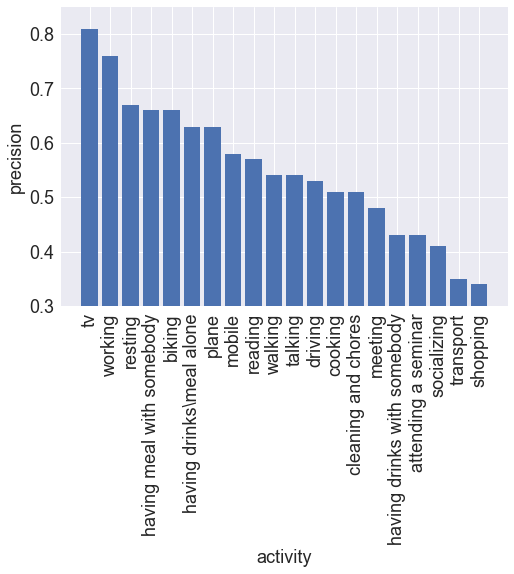

In [22]:
a = classification_report(y_test,y_pred_rf)
a= a.split('\n')
precision=[]
x_act = sorted(y.unique())
for i,v in enumerate(a):
    if i>=2:      
        if (v != ''):
            if 'avg' not in v:                
                value= float(v[33:39])
                precision.append(value)                

activity_score={}
for i,v in enumerate(x_act):
    activity_score[v]=precision[i]
    
list= sorted(activity_score.items(), key=lambda x:x[1],reverse=True)
#print list
x_val = [x[0] for x in list]
y_val = [x[1] for x in list]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val)
plt.xlabel('activity',fontsize = 18)
plt.ylim([0.3,0.85])
plt.ylabel('precision',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()

[('walking', 5453), ('working', 4476), ('mobile', 3294), ('resting', 3272), ('transport', 2723), ('driving', 2012), ('talking', 1839), ('socializing', 1276), ('meeting', 1234), ('having drinks\\meal alone', 1116), ('having drinks with somebody', 1016), ('tv', 853), ('shopping', 820), ('reading', 807), ('plane', 730), ('having meal with somebody', 721), ('attending a seminar', 719), ('cleaning and chores', 533), ('cooking', 367), ('biking', 168)]


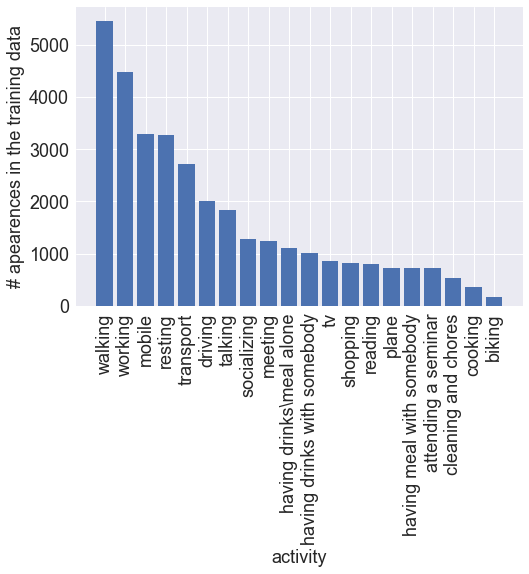

In [16]:
activity_occurences={}
for val in x_val:
    activity_occurences[val]=y_train[y_train==val].count()
    
list1= sorted(activity_occurences.items(), key=lambda x:x[1],reverse=True)
print list1
x_val = [x[0] for x in list1]
y_val = [x[1] for x in list1]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val,log=False)
plt.xlabel('activity',fontsize = 18)
plt.ylabel('# apearences in the training data',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()    


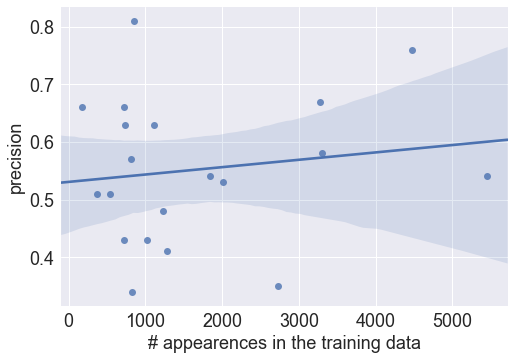

In [17]:
values = np.zeros((len(list),2))
for i in range(len(list)):
    tag = list[i][0]
    valor = list[i][1]
    values[i,1]=activity_occurences[tag]
    values[i,0] = valor
    
sns.regplot(values[:,1], values[:,0],order=1)
plt.xlabel('# appearences in the training data',fontsize = 18)
plt.ylabel('precision',fontsize=18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.show()     

In [51]:
def plot_confusion_matrix(test, pred,normalize=False):
    cm=confusion_matrix(test,pred)
    
    if normalize: 
        cm = cm.astype('float')/cm.sum(axis= 1)
        plt.imshow(cm,cmap=plt.cm.jet, interpolation='nearest')
        plt.colorbar()
        plt.xlabel('predict label',fontsize= 18)
        plt.ylabel('true label',fontsize= 18)
        x_act= np.sort(y.unique())   
        plt.xticks(np.arange(0,len(x_act)),x_act,rotation=90,fontsize= 18)
        plt.yticks(np.arange(0,len(x_act)),x_act,rotation=0,fontsize= 18)
        plt.grid('off')
        plt.show()
        return cm
    else:
        plt.imshow(cm,cmap=plt.cm.jet, interpolation='nearest')
        plt.colorbar()
        plt.xlabel('predict label',fontsize= 18)
        plt.ylabel('true label',fontsize= 18)
        x_act= np.sort(y.unique())   
        plt.xticks(np.arange(0,len(x_act)),x_act,rotation=90,fontsize= 18)
        plt.yticks(np.arange(0,len(x_act)),x_act,rotation=0,fontsize= 18)
        plt.grid('off')
        plt.show()
        return cm
    
    

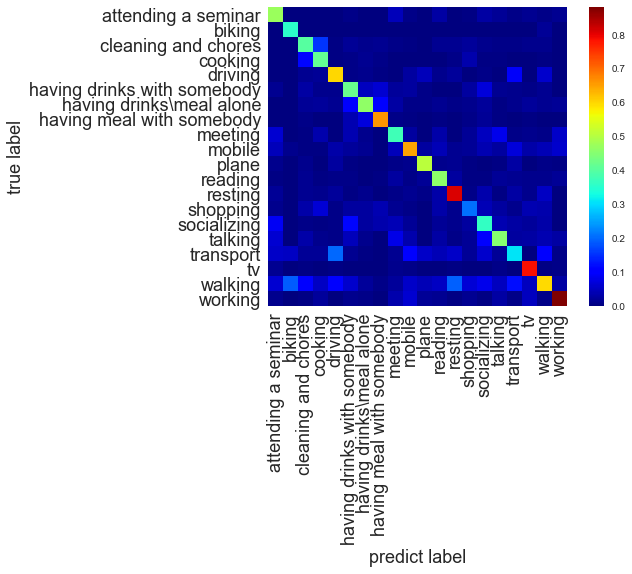

In [106]:
a=plot_confusion_matrix(y_test,y_pred_rf,normalize=True)

In [20]:
print "classification accuracy:", accuracy_score(y_test, y_pred_rf)
print "classification accuracy:", rf.score(X_test, y_test)

classification accuracy: 0.584031267448
classification accuracy: 0.584031267448


Our next try is to add two more binary columns: one containing information about location (is he/she at Home or not?) and another about time (Is today Weekend or not?). Our belive is that these two informations will result in a better accuracy. 

In [63]:
mask =  df['location'] == 'Home'
mask = mask.astype(int)

In [64]:
df1=df.copy()

In [65]:
df1['Home'] = mask

In [66]:
mask = df['day_of_week'] > 4
mask = mask.astype(int)

In [67]:
df1['Weekend'] = mask

In [68]:
tags1=['person','chair', 'book', 'tvmonitor', 'laptop', 'bottle','cup', 'car','diningtable', 'cell phone',
             'keyboard', 'bowl', 'mouse', 'clock','toilet', 'sink', 'remote', 'suitcase', 'pottedplant','refrigerator',
             'knife', 'handbag', 'vase', 'aeroplane', 'cat','bed', 'sofa', 'backpack', 'tie', 'spoon', 'toothbrush',
             'traffic light', 'bicycle', 'train', 'bird', 'microwave', 'bench','fork', 'oven', 'motorbike', 'donut',
             'wine glass', 'pizza','apple', 'scissors', 'umbrella', 'cake', 'bus', 'truck','banana', 'parking meter',
             'sandwich', 'sports ball', 'broccoli','carrot', 'orange', 'teddy bear', 'dog', 'snowboard','skateboard', 'boat',
             'surfboard', 'frisbee', 'skis', 'hot dog','bear', 'elephant', 'toaster', 'stop sign', 'hair drier', 'kite',
             'sheep', 'zebra', 'tennis racket', 'baseball bat', 'fire hydrant','horse', 'cow', 'giraffe', 'baseball glove','Home','Weekend']


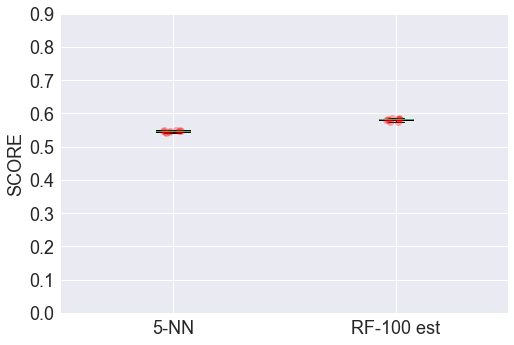

In [29]:
y = df1['activity']
X = df1[tags]

PRC = 0.3
acc_r=np.zeros((10,2))
for i in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
    knn = KNeighborsClassifier(n_neighbors=5)
    rf = RandomForestClassifier(n_estimators=100)
    knn.fit(X_train,y_train)
    rf.fit(X_train,y_train)   
    y_pred_knn= knn.predict(X_test)
    y_pred_rf = rf.predict(X_test)
    acc_r[i][0] = accuracy_score(y_test,y_pred_knn)
    acc_r[i][1] = accuracy_score(y_test,y_pred_rf)
    
plt.boxplot(acc_r)
for i in xrange(2):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['5-NN','RF-100 est'],fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylim([0, 0.9])
plt.ylabel('SCORE',fontsize= 18)
plt.show()


In [30]:
print classification_report(y_test,y_pred_rf)

                             precision    recall  f1-score   support

        attending a seminar       0.49      0.43      0.46       334
                     biking       0.58      0.39      0.47        64
        cleaning and chores       0.49      0.31      0.38       243
                    cooking       0.52      0.41      0.46       164
                    driving       0.58      0.60      0.59       884
having drinks with somebody       0.45      0.45      0.45       443
   having drinks\meal alone       0.64      0.46      0.54       462
  having meal with somebody       0.74      0.62      0.67       320
                    meeting       0.45      0.34      0.39       527
                     mobile       0.60      0.67      0.63      1420
                      plane       0.62      0.52      0.57       288
                    reading       0.55      0.49      0.51       344
                    resting       0.66      0.82      0.73      1463
                   shopping      

In [31]:
y_train[y_train == 'biking'].count()

187

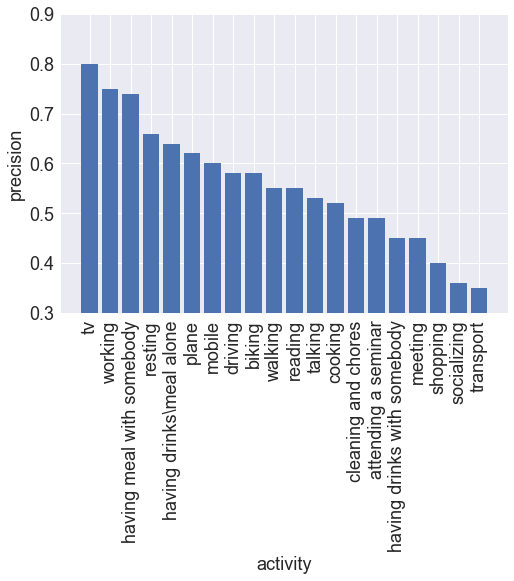

In [32]:
a = classification_report(y_test,y_pred_rf)
a= a.split('\n')
precision=[]
x_act = sorted(y.unique())
for i,v in enumerate(a):
    if i>=2:      
        if (v != ''):
            if 'avg' not in v:                
                value= float(v[33:39])
                precision.append(value)                

activity_score={}
for i,v in enumerate(x_act):
    activity_score[v]=precision[i]
    
list= sorted(activity_score.items(), key=lambda x:x[1],reverse=True)
#print list
x_val = [x[0] for x in list]
y_val = [x[1] for x in list]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val)
plt.xlabel('activity',fontsize = 18)
plt.ylim([0.3,0.9])
plt.ylabel('precision',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()

[('walking', 5374), ('working', 4482), ('resting', 3346), ('mobile', 3274), ('transport', 2783), ('driving', 1982), ('talking', 1829), ('socializing', 1291), ('meeting', 1249), ('having drinks\\meal alone', 1125), ('having drinks with somebody', 975), ('tv', 842), ('reading', 823), ('shopping', 790), ('plane', 742), ('having meal with somebody', 713), ('attending a seminar', 689), ('cleaning and chores', 550), ('cooking', 383), ('biking', 187)]


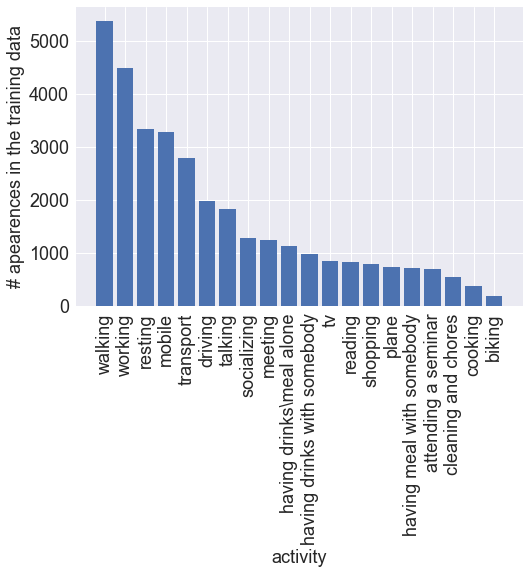

In [33]:
activity_occurences={}
for val in x_val:
    activity_occurences[val]=y_train[y_train==val].count()
    
list1= sorted(activity_occurences.items(), key=lambda x:x[1],reverse=True)
print list1
x_val = [x[0] for x in list1]
y_val = [x[1] for x in list1]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val,log=False)
plt.xlabel('activity',fontsize = 18)
plt.ylabel('# apearences in the training data',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()    


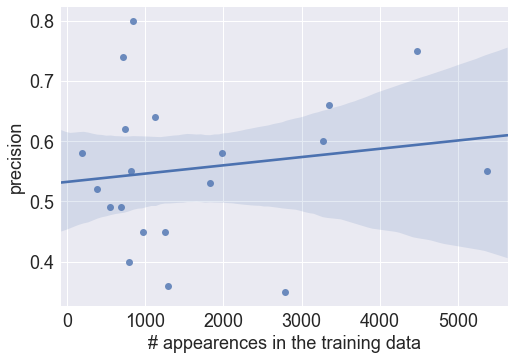

In [34]:
values = np.zeros((len(list),2))
for i in range(len(list)):
    tag = list[i][0]
    valor = list[i][1]
    values[i,1]=activity_occurences[tag]
    values[i,0] = valor
    
sns.regplot(values[:,1], values[:,0],order=1)
plt.xlabel('# appearences in the training data',fontsize = 18)
plt.ylabel('precision',fontsize=18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.show()     

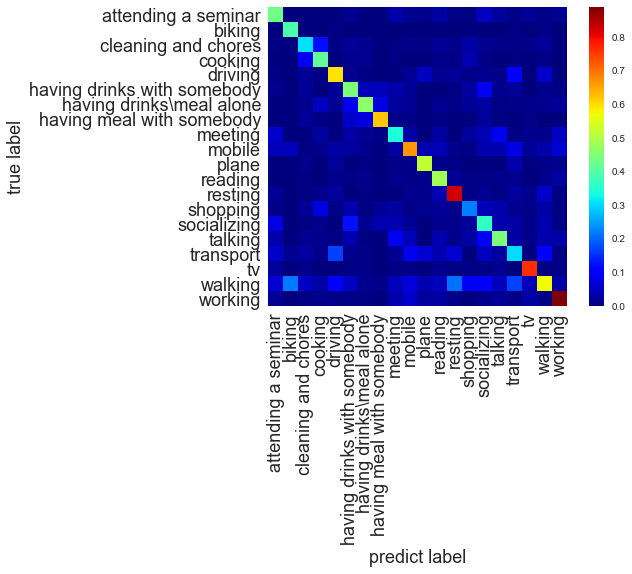

In [35]:
plot_confusion_matrix(y_test, y_pred_rf,normalize=True)

Our next try is to scan each image and extract 8-bins for each RGB channel and add this information to the confusion matrix. In our case, the dataframe imported at the beginig is already filled with such information (See the folder "1.Clean data and add extra features"). Let's see how well it performs now:

This are the new tags that we will add to the previous used tags:

In [69]:
tags_rgb = ['R_bin1', 'R_bin2', 'R_bin3', 'R_bin4', 'R_bin5', 'R_bin6', 'R_bin7', 'R_bin8','G_bin1', 'G_bin2', 'G_bin3', 'G_bin4', 'G_bin5', 'G_bin6', 'G_bin7', 'G_bin8','B_bin1', 'B_bin2', 'B_bin3', 'B_bin4', 'B_bin5', 'B_bin6', 'B_bin7', 'B_bin8']

In [70]:
tags2 = tags1 + tags_rgb

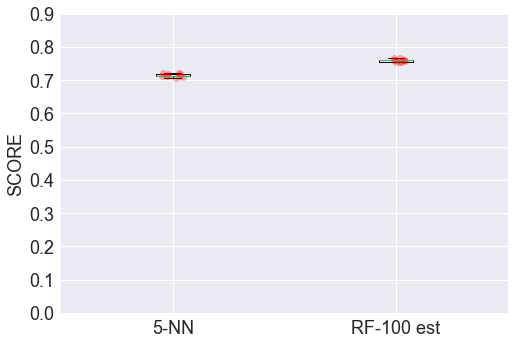

In [71]:
#FULL DETAIL DATA: probability 
y = df1['activity']
X = df1[tags2]

PRC = 0.3
acc_r=np.zeros((10,2))
for i in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
    knn = KNeighborsClassifier(n_neighbors=5)
    rf = RandomForestClassifier(n_estimators=100)
    knn.fit(X_train,y_train)
    rf.fit(X_train,y_train)   
    y_pred_knn= knn.predict(X_test)
    y_pred_rf = rf.predict(X_test)
    acc_r[i][0] = accuracy_score(y_test,y_pred_knn)
    acc_r[i][1] = accuracy_score(y_test,y_pred_rf)
    
plt.boxplot(acc_r)
for i in xrange(2):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['5-NN','RF-100 est'],fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylim([0, 0.9])
plt.ylabel('SCORE',fontsize= 18)
plt.show()


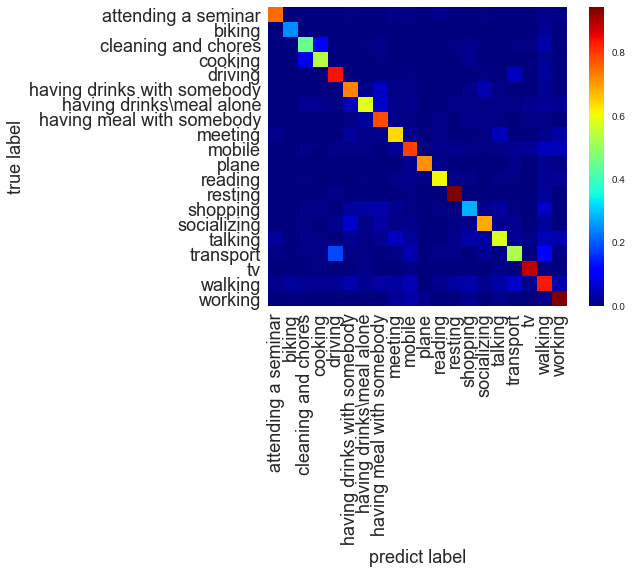

array([[  7.50798722e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.97512438e-03,
          0.00000000e+00,   0.00000000e+00,   9.63391137e-03,
          5.05780347e-03,   0.00000000e+00,   1.13960114e-02,
          2.09059233e-03,   0.00000000e+00,   5.30035336e-03,
          1.24069479e-03,   3.49650350e-03,   0.00000000e+00,
          1.33047210e-02,   9.39947781e-03],
       [  0.00000000e+00,   2.50000000e-01,   0.00000000e+00,
          0.00000000e+00,   1.18063754e-03,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          7.22543353e-04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.24069479e-03,   1.74825175e-03,   0.00000000e+00,
          2.10300429e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   4.50199203e-01,
          1.20000000e-01,   0.00000000e+00,   2.48756219e-03,
          6.39658849e-03,   1.38408304e-02

In [72]:
plot_confusion_matrix(y_test, y_pred_rf,normalize=True)

Our final try is to add the last activity performed to the features matrix. 

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
#asigning a value to each of the activities from 0 to 1 (normalized)
dic_act={}
val=np.linspace(0,1,20)
for i,v in enumerate(y.unique()):
    dic_act[v]=val[i]


Each activity has a reference number normalized from 0 to 1:

In [75]:
dic_act

{'attending a seminar': 0.57894736842105265,
 'biking': 1.0,
 'cleaning and chores': 0.78947368421052633,
 'cooking': 0.052631578947368418,
 'driving': 0.31578947368421051,
 'having drinks with somebody': 0.84210526315789469,
 'having drinks\\meal alone': 0.10526315789473684,
 'having meal with somebody': 0.68421052631578938,
 'meeting': 0.89473684210526305,
 'mobile': 0.0,
 'plane': 0.94736842105263153,
 'reading': 0.42105263157894735,
 'resting': 0.21052631578947367,
 'shopping': 0.63157894736842102,
 'socializing': 0.36842105263157893,
 'talking': 0.47368421052631576,
 'transport': 0.73684210526315785,
 'tv': 0.15789473684210525,
 'walking': 0.26315789473684209,
 'working': 0.52631578947368418}

In [76]:
df1.head()

,user,age,day_id,date,image_directory,activity,image_id,image_path,location,gender,...,B_bin1,B_bin2,B_bin3,B_bin4,B_bin5,B_bin6,B_bin7,B_bin8,Home,Weekend
2015-02-23 07:08:12,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,mobile,u1_2015-02-23_070812_6,/u1/2015-02-23/b00000006_21i6bq_20150223_07081...,Home,male,...,0.022873,0.256494,0.174103,0.303694,0.250870,0.168284,0.019045,0.061411,1,0
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_7,/u1/2015-02-23/b00000007_21i6bq_20150223_07081...,Home,male,...,0.067223,0.143474,0.209524,0.444543,0.343550,0.001700,0.000072,0.000061,1,0
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_8,/u1/2015-02-23/b00000008_21i6bq_20150223_07081...,Home,male,...,0.155595,0.260709,0.214408,0.441503,0.075073,0.009980,0.005148,0.011784,1,0
2015-02-23 07:08:14,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070814_9,/u1/2015-02-23/b00000009_21i6bq_20150223_07081...,Home,male,...,0.136579,0.447956,0.280991,0.263809,0.031977,0.004851,0.002074,0.001339,1,0
2015-02-23 07:08:22,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070822_10,/u1/2015-02-23/b00000010_21i6bq_20150223_07082...,Home,male,...,0.044834,0.181883,0.267774,0.521107,0.135849,0.002264,0.002486,0.053487,1,0


In [77]:
def get_previous_act(): # function to get the previous activity
    data=df1.activity.values
    val= []
    X = df1[tags2]
    
    for item in range(len(data)): #For each element in the dataframe:
        if item == 0: # We predict the activity for the first element
            result1 = rf.predict(X.ix[item,:])
            valor_previ = np.nan
            val.append(np.nan)
            
        else:
            result2 = rf.predict(X.ix[item,:])
            if result2!=result1: #check if previous activity is different
                val.append(dic_act[result1[0]])
                valor_previ = dic_act[result1[0]]
                result1 = result2
            else:
                val.append(valor_previ)  #If it's not different, we save the previous value
                
    return val

dummy= get_previous_act()


In [78]:
df2=df1.copy()
df2['prev_activity'] = pd.Series(dummy, index=df.index)

In [79]:
tags=['prev_activity']


In [80]:
tags3= tags2+tags

In [81]:
df2 = df2.dropna(how='any',subset=["activity"],axis=0)


In [82]:
df2.head()

,user,age,day_id,date,image_directory,activity,image_id,image_path,location,gender,...,B_bin2,B_bin3,B_bin4,B_bin5,B_bin6,B_bin7,B_bin8,Home,Weekend,prev_activity
2015-02-23 07:08:12,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,mobile,u1_2015-02-23_070812_6,/u1/2015-02-23/b00000006_21i6bq_20150223_07081...,Home,male,...,0.256494,0.174103,0.303694,0.250870,0.168284,0.019045,0.061411,1,0,NaN
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_7,/u1/2015-02-23/b00000007_21i6bq_20150223_07081...,Home,male,...,0.143474,0.209524,0.444543,0.343550,0.001700,0.000072,0.000061,1,0,0.0
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_8,/u1/2015-02-23/b00000008_21i6bq_20150223_07081...,Home,male,...,0.260709,0.214408,0.441503,0.075073,0.009980,0.005148,0.011784,1,0,0.0
2015-02-23 07:08:14,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070814_9,/u1/2015-02-23/b00000009_21i6bq_20150223_07081...,Home,male,...,0.447956,0.280991,0.263809,0.031977,0.004851,0.002074,0.001339,1,0,0.0
2015-02-23 07:08:22,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070822_10,/u1/2015-02-23/b00000010_21i6bq_20150223_07082...,Home,male,...,0.181883,0.267774,0.521107,0.135849,0.002264,0.002486,0.053487,1,0,0.0


We have now a new column with information about the previous activity performed at certain time. Let's see if there is an improvement:

In [83]:
#FULL DETAIL DATA: probability 
y = df2[1:]['activity'] #remove the 1st data point
X = df2[1:][tags3] #remove the 1st data point

PRC = 0.3
acc_r=np.zeros((10,2))
for i in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
    knn = KNeighborsClassifier(n_neighbors=5)
    rf = RandomForestClassifier(n_estimators=100)
    knn.fit(X_train,y_train)
    rf.fit(X_train,y_train)   
    y_pred_knn= knn.predict(X_test)
    y_pred_rf = rf.predict(X_test)
    acc_r[i][0] = accuracy_score(y_test,y_pred_knn)
    acc_r[i][1] = accuracy_score(y_test,y_pred_rf)

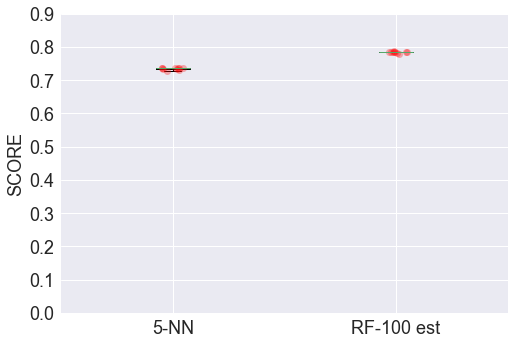

In [84]:
plt.boxplot(acc_r)
for i in xrange(2):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['5-NN','RF-100 est'],fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylim([0, 0.9])
plt.ylabel('SCORE',fontsize= 18)
plt.show()


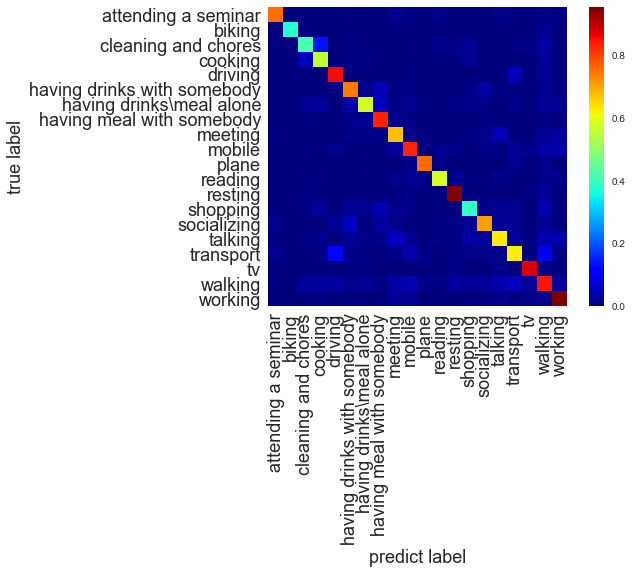

In [85]:
a=plot_confusion_matrix(y_test, y_pred_rf,normalize=True)

In [86]:
print classification_report(y_test,y_pred_rf)

                             precision    recall  f1-score   support

        attending a seminar       0.94      0.75      0.84       305
                     biking       1.00      0.38      0.55        71
        cleaning and chores       0.77      0.42      0.55       248
                    cooking       0.70      0.56      0.62       176
                    driving       0.81      0.85      0.83       834
having drinks with somebody       0.78      0.75      0.76       420
   having drinks\meal alone       0.83      0.58      0.68       470
  having meal with somebody       0.80      0.83      0.82       320
                    meeting       0.76      0.67      0.72       512
                     mobile       0.78      0.83      0.81      1384
                      plane       0.95      0.76      0.85       300
                    reading       0.89      0.58      0.70       339
                    resting       0.90      0.95      0.92      1469
                   shopping      

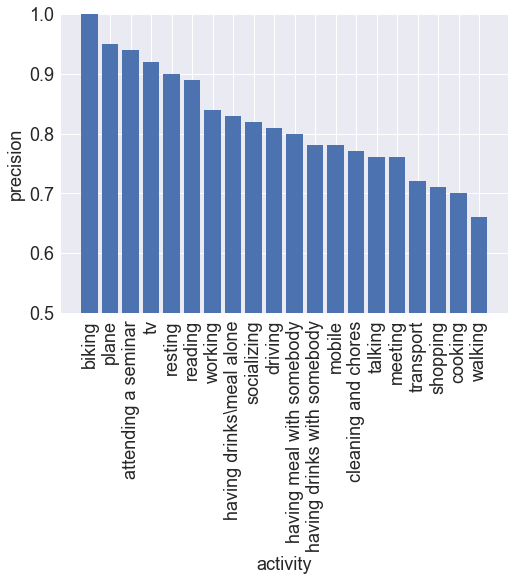

In [87]:
a = classification_report(y_test,y_pred_rf)
a= a.split('\n')
precision=[]
x_act = sorted(y.unique())
for i,v in enumerate(a):
    if i>=2:      
        if (v != ''):
            if 'avg' not in v:   
                
                value= float(v[33:39])
                
                precision.append(value)                

activity_score={}
for i,v in enumerate(x_act):
    activity_score[v]=precision[i]
    
list= sorted(activity_score.items(), key=lambda x:x[1],reverse=True)
#print list
x_val = [x[0] for x in list]
y_val = [x[1] for x in list]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val)
plt.xlabel('activity',fontsize = 18)
plt.ylim([0.5,1.0])
plt.ylabel('precision',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()

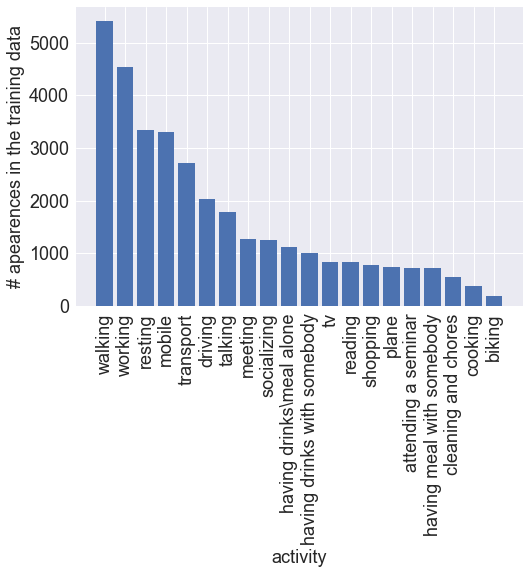

In [88]:
activity_occurences={}
for val in x_val:
    activity_occurences[val]=y_train[y_train==val].count()
   
list1= sorted(activity_occurences.items(), key=lambda x:x[1],reverse=True)

x_val = [x[0] for x in list1]
y_val = [x[1] for x in list1]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val,log=False)
plt.xlabel('activity',fontsize = 18)
plt.ylabel('# apearences in the training data',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()    


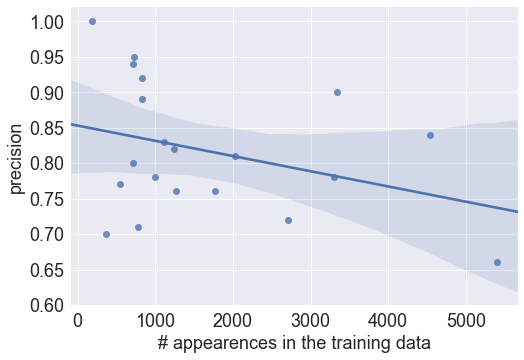

In [89]:
values = np.zeros((len(list),2))
for i in range(len(list)):
    tag = list[i][0]
    valor = list[i][1]
    values[i,1]=activity_occurences[tag]
    values[i,0] = valor
    
sns.regplot(values[:,1], values[:,0],order=1)
plt.xlabel('# appearences in the training data',fontsize = 18)
plt.ylabel('precision',fontsize=18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
#plt.ylim([0.4,1])
plt.show()     

Let's train our system with data from user 1 and 2, and try to predict the activity of user 3:

In [93]:
#train and test from diffent users
#TRAIN data is made up using user 1 and 2 information 
df_train = df2[df2['user'] !='u3']
y = df_train[1:]['activity']
X = df_train[1:][tags3]
# TEST data is made up using user 3 information only
df_test =df2[df2['user']=='u3']
test_data= df_test[tags3]
y_data =df_test['activity']
#####

In [94]:
#print unique activity labels for train and test data
print np.sort(y.unique()) 
print np.sort(y_data.unique())

['attending a seminar' 'biking' 'cleaning and chores' 'cooking' 'driving'
 'having drinks with somebody' 'having drinks\\meal alone'
 'having meal with somebody' 'meeting' 'mobile' 'plane' 'reading' 'resting'
 'shopping' 'socializing' 'talking' 'transport' 'tv' 'walking' 'working']
['cleaning and chores' 'cooking' 'driving' 'having drinks with somebody'
 'having drinks\\meal alone' 'having meal with somebody' 'mobile' 'plane'
 'reading' 'resting' 'shopping' 'socializing' 'talking' 'transport' 'tv'
 'walking' 'working']


In [95]:
df_train.head(2)

,user,age,day_id,date,image_directory,activity,image_id,image_path,location,gender,...,B_bin2,B_bin3,B_bin4,B_bin5,B_bin6,B_bin7,B_bin8,Home,Weekend,prev_activity
2015-02-23 07:08:12,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,mobile,u1_2015-02-23_070812_6,/u1/2015-02-23/b00000006_21i6bq_20150223_07081...,Home,male,...,0.256494,0.174103,0.303694,0.25087,0.168284,0.019045,0.061411,1,0,NaN
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_7,/u1/2015-02-23/b00000007_21i6bq_20150223_07081...,Home,male,...,0.143474,0.209524,0.444543,0.34355,0.001700,0.000072,0.000061,1,0,0.0


In [96]:
# remove the activities that are not present for user3 in the training data
df_train=df_train[df_train['activity']!= 'attending a seminar']
df_train=df_train[df_train['activity']!= 'biking']
df_train=df_train[df_train['activity']!= 'meeting']
                  

In [97]:
#TRAIN data is with user 1 and 2 
y = df_train[1:]['activity']
X = df_train[1:][tags3]

In [98]:

knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100)
knn.fit(X_train,y_train)
rf.fit(X_train,y_train)   
y_pred_knn= knn.predict(test_data)
y_pred_rf = rf.predict(test_data)

In [99]:
print classification_report(y_data,y_pred_rf)

                             precision    recall  f1-score   support

        attending a seminar       0.00      0.00      0.00         0
        cleaning and chores       0.96      0.84      0.89       158
                    cooking       0.96      0.86      0.91       179
                    driving       0.97      0.97      0.97       681
having drinks with somebody       0.97      0.94      0.96       831
   having drinks\meal alone       0.97      0.91      0.94       581
  having meal with somebody       0.95      0.89      0.92       198
                    meeting       0.00      0.00      0.00         0
                     mobile       0.97      0.98      0.97      2351
                      plane       0.99      0.98      0.98       328
                    reading       0.67      0.73      0.70        11
                    resting       0.98      1.00      0.99      2432
                   shopping       0.97      0.84      0.90       268
                socializing      

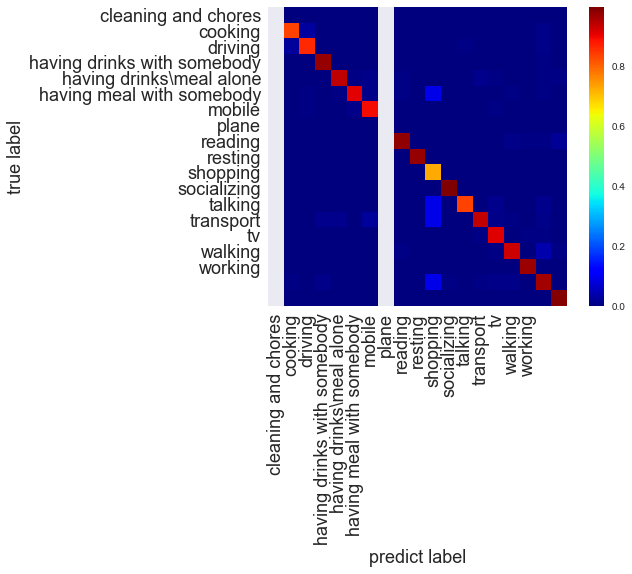

array([[             nan,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,              nan,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [             nan,   8.35443038e-01,   2.79329609e-02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,              nan,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.11184211e-04,
          0.00000000e+00,   0.00000000e+00,   3.89105058e-03,
          2.75292498e-03,   2.03252033e-03,   8.30860534e-03,
          0.00000000e+00],
       [             nan,   2.53164557e-02,   8.60335196e-01,
          0.00000000e+00,   0.00000000e+00,   3.44234079e-03,
          0.00000000e+00,              nan,   8.50701829e-04,
          0.0000

In [111]:
plot_confusion_matrix(y_data,y_pred_rf,normalize=True)

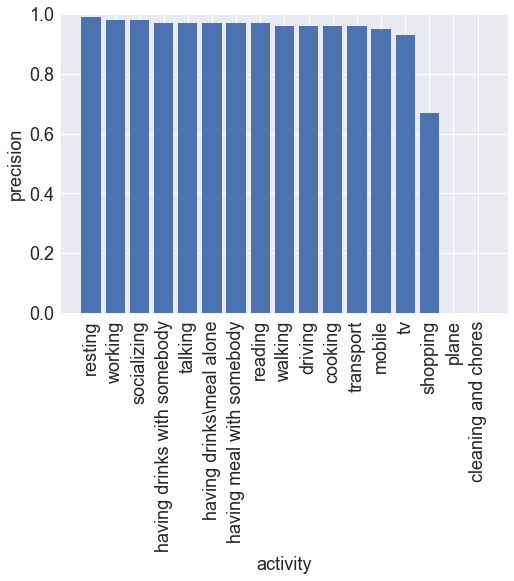

In [101]:
a = classification_report(y_data,y_pred_rf)
a= a.split('\n')
precision=[]
x_act = sorted(y_data.unique())
for i,v in enumerate(a):
    if i>=2:      
        if (v != ''):
            if 'avg' not in v:   
                value= float(v[33:39])
                precision.append(value) 

activity_score={}
for i,v in enumerate(x_act):
    activity_score[v]=precision[i]
    
list= sorted(activity_score.items(), key=lambda x:x[1],reverse=True)
#print list
x_val = [x[0] for x in list]
y_val = [x[1] for x in list]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val)
plt.xlabel('activity',fontsize = 18)
plt.ylim([0.0,1.0])
plt.ylabel('precision',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()

In [102]:
print "classification accuracy:", accuracy_score(y_data, y_pred_rf)

classification accuracy: 0.957035840188


In [ ]:
#TEST MODEL FOR EVERY USER INDIVIDUALLY

In [103]:
df_user1=df2[df2['user']=='u1']
df_user2=df2[df2['user']=='u2']
df_user3=df2[df2['user']=='u3']
y1 = df_user1[1:]['activity']
X1 = df_user1[1:][tags3]
y2 = df_user2[1:]['activity']
X2 = df_user2[1:][tags3]
y3 = df_user3[1:]['activity']
X3 = df_user3[1:][tags3]

In [104]:
PRC = 0.3
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=PRC)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=PRC)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=PRC)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train1,y_train1)   
y_pred_rf1 = rf.predict(X_test1)
print "classification accuracy:", accuracy_score(y_test1, y_pred_rf1)
rf.fit(X_train2,y_train2)   
y_pred_rf2 = rf.predict(X_test2)
print "classification accuracy:", accuracy_score(y_test2, y_pred_rf2)
rf.fit(X_train1,y_train1)   
y_pred_rf3 = rf.predict(X_test3)
print "classification accuracy:", accuracy_score(y_test3, y_pred_rf3)

classification accuracy: 0.756044355572
classification accuracy: 0.800506115563
classification accuracy: 0.357405140759
